In [10]:
import climakitae as ck
from climakitae.core.data_interface import get_data, get_subsetting_options

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

In [11]:
PARK_NAME = "Mojave National Preserve"
LAT_SLICE = (34.5, 35.5)
LON_SLICE = (-116.5, -114.5)

SCENARIOS = [
    "Historical Climate",
    "SSP 2-4.5",
    "SSP 3-7.0",
    "SSP 5-8.5",
]

TIMESPAN = (1950, 2099)
BASELINE_START = 1995
BASELINE_END = 2014
SMOOTH_WIN = 11

print("Config OK")

Config OK


In [12]:
def load_var_box_mean(variable_name):
    ds = get_data(
        variable=variable_name,
        resolution="3 km",
        timescale="monthly",
        scenario=SCENARIOS,
        time_slice=TIMESPAN,
        latitude=LAT_SLICE,
        longitude=LON_SLICE,
    )

    if (ds is None) or (hasattr(ds, "time") and ds.time.size == 0):
        print(f"[{variable_name}] No data with lat/lon slice, trying full domain...")
        ds = get_data(
            variable=variable_name,
            resolution="3 km",
            timescale="monthly",
            scenario=SCENARIOS,
            time_slice=TIMESPAN,
        )
        if ds is None or ds.time.size == 0:
            raise ValueError(f"[{variable_name}] get_data returned no data at all. Check variable/scenario names.")

        if "lat" in ds.coords and "lon" in ds.coords:
            ds = ds.sel(
                lat=slice(LAT_SLICE[0], LAT_SLICE[1]),
                lon=slice(LON_SLICE[0], LON_SLICE[1]),
            )

    if isinstance(ds, xr.Dataset):
        var_name = list(ds.data_vars)[0]
        da = ds[var_name]
    else:
        da = ds

    spatial_dims = []
    for cand in [("lat", "lon"), ("y", "x")]:
        if all(d in da.dims for d in cand):
            spatial_dims = list(cand)
            break

    if not spatial_dims:
        spatial_dims = [
            d for d in da.dims
            if d not in ("time", "scenario", "simulation", "member", "realization")
        ]

    if spatial_dims:
        da = da.mean(dim=spatial_dims)

    return da

In [13]:
tas = load_var_box_mean("Air Temperature at 2m")
pr = load_var_box_mean("Precipitation (total)")

tas, pr

(<xarray.DataArray np.str_('Air Temperature at 2m') (scenario: 1, simulation: 8,
                                                     time: 1432)> Size: 46kB
 dask.array<mean_agg-aggregate, shape=(1, 8, 1432), dtype=float32, chunksize=(1, 1, 538), chunktype=numpy.ndarray>
 Coordinates:
   * time               (time) datetime64[ns] 11kB 1980-09-01 ... 2099-12-01
     Lambert_Conformal  int64 8B 0
   * simulation         (simulation) <U26 832B 'WRF_MIROC6_r1i1p1f1' ... 'WRF_...
   * scenario           (scenario) <U22 88B 'Historical + SSP 3-7.0'
 Attributes:
     variable_id:           t2
     extended_description:  Temperature of the air 2m above Earth's surface. T...
     units:                 K
     data_type:             Gridded
     resolution:            3 km
     frequency:             monthly
     location_subset:       ['coordinate selection']
     approach:              Time
     downscaling_method:    Dynamical
     institution:           UCLA
     grid_mapping:          Lamb

In [15]:
if tas.attrs.get("units", "").lower().startswith("k"):
    tas = tas - 273.15
    tas.attrs["units"] = "°C"

if pr.attrs.get("units") in ["kg/m^2/s", "kg m-2 s-1"]:
    days = pr.time.dt.days_in_month
    pr = pr * 86400 * days
    pr.attrs["units"] = "mm/month"

tas.attrs, pr.attrs

({'variable_id': 't2',
  'extended_description': 'Temperature of the air 2m above Earth\'s surface. This is the standard measure of air temperature used for most modeling applications and is also referred to as "Ambient Temperature".',
  'units': '°C',
  'data_type': 'Gridded',
  'resolution': np.str_('3 km'),
  'frequency': np.str_('monthly'),
  'location_subset': ['coordinate selection'],
  'approach': 'Time',
  'downscaling_method': np.str_('Dynamical'),
  'institution': 'UCLA',
  'grid_mapping': 'Lambert_Conformal'},
 {'variable_id': 'prec',
  'extended_description': 'Total precipitation. Computed by summing total gridscale precipitation and total cumulus precipitation.',
  'units': 'mm',
  'data_type': 'Gridded',
  'resolution': np.str_('3 km'),
  'frequency': np.str_('monthly'),
  'location_subset': ['coordinate selection'],
  'approach': 'Time',
  'downscaling_method': np.str_('Dynamical'),
  'institution': 'UCLA',
  'grid_mapping': 'Lambert_Conformal'})

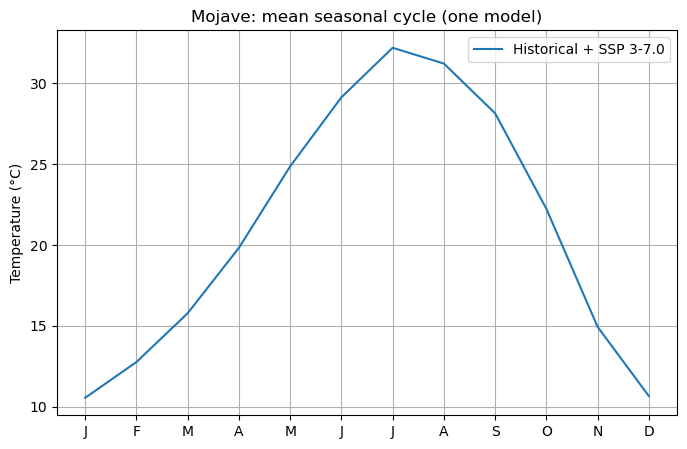

In [16]:
if "simulation" in tas.dims:
    tas_one = tas.isel(simulation=0)
else:
    tas_one = tas

fig, ax = plt.subplots()

for scen in tas_one.scenario.values:
    clim = tas_one.sel(scenario=scen).groupby("time.month").mean("time")
    ax.plot(range(1, 13), clim, label=scen)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list("JFMAMJJASOND"))
ax.set_ylabel("Temperature (°C)")
ax.set_title("Mojave: mean seasonal cycle (one model)")
ax.legend()
plt.show()

/opt/conda/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


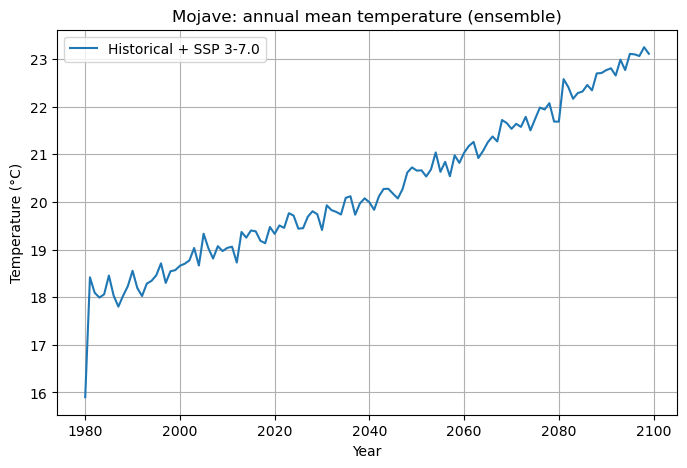

In [17]:
tas_annual = tas.resample(time="A").mean()
years = tas_annual.time.dt.year

fig, ax = plt.subplots()

for scen in tas_annual.scenario.values:
    da = tas_annual.sel(scenario=scen)
    if "simulation" in da.dims:
        y = da.mean("simulation")
    else:
        y = da
    ax.plot(years, y, label=scen)

ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Mojave: annual mean temperature (ensemble)")
ax.legend()
plt.show()

/opt/conda/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


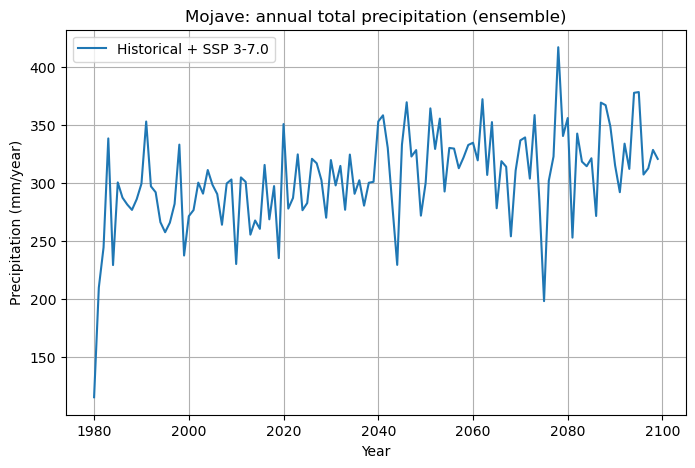

In [18]:
pr_annual = pr.resample(time="A").sum()

fig, ax = plt.subplots()

for scen in pr_annual.scenario.values:
    da = pr_annual.sel(scenario=scen)
    if "simulation" in da.dims:
        y = da.mean("simulation")
    else:
        y = da
    ax.plot(pr_annual.time.dt.year, y, label=scen)

ax.set_xlabel("Year")
ax.set_ylabel("Precipitation (mm/year)")
ax.set_title("Mojave: annual total precipitation (ensemble)")
ax.legend()
plt.show()

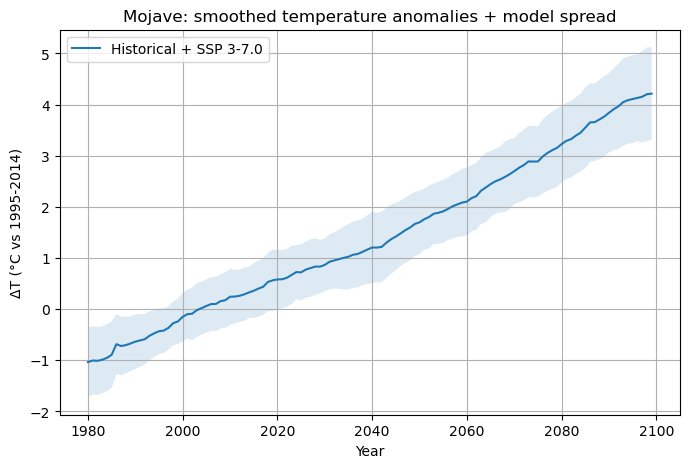

In [23]:
import pandas as pd

BASELINE_START = 1995
BASELINE_END = 2014
SMOOTH_WIN = 11

tas_y = tas.groupby("time.year").mean("time")

fig, ax = plt.subplots()

for scen in tas_y.scenario.values:
    da = tas_y.sel(scenario=scen)
    base = da.sel(year=slice(BASELINE_START, BASELINE_END)).mean("year")
    anom = da - base

    if "simulation" in anom.dims:
        ens_mean = anom.mean("simulation")
        ens_std = anom.std("simulation")
    else:
        ens_mean = anom
        ens_std = xr.zeros_like(ens_mean)

    years = ens_mean.year.values
    mean_vals = np.asarray(ens_mean.values).squeeze()
    std_vals = np.asarray(ens_std.values).squeeze()

    mean_s = pd.Series(mean_vals, index=years).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().values
    std_s = pd.Series(std_vals, index=years).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().values

    ax.plot(years, mean_s, label=str(scen))
    ax.fill_between(years, mean_s - std_s, mean_s + std_s, alpha=0.15)

ax.set_xlabel("Year")
ax.set_ylabel(f"ΔT (°C vs {BASELINE_START}-{BASELINE_END})")
ax.set_title("Mojave: smoothed temperature anomalies + model spread")
ax.legend()
plt.show()